Importing

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import scipy as sp
from scipy.integrate import odeint

Creating the function for the ODE

In [80]:
def model(z, t, betaD, betaR, v, n, m, k, M):
    D = z[:k]
    R = z[k:2*k]
    D_n = M@z[:k]
    dDdT = v * (betaD / (1 + R ** n) - D)
    dRdt = betaR * D_n**m / (1 + D_n**m) -R
    return np.ravel([dDdT, dRdt])

Finding the Neighbours for each cell

In [81]:
# def pq2ind(p, q, P):
#     return p + (q-1)*P
# 
# def ind2pq(ind, P):
#     q = 1 + (ind-1)//P
#     p = ind - (q-1)*P
#     return p, q
# 
# def find_neighbours(ind, P, Q):
#     out = []
#     p, q = ind2pq(ind, P)
#     out[0] = pq2ind((p%P)+1, q, P)
#     out[1] = pq2ind(((p-2)%P)+1, q, P)
#     qleft = ((q-2)%Q)+1
#     qright = (q%Q)+1
#     if q/2 != np.round(q/2):
#         pup = p
#         pdown = ((p-2)%P)+1
#     else:
#         pup = (p%P)+1
#         pdown = p
#     out[2] = pq2ind(pup,qleft,P)
#     out[3] = pq2ind(pdown,qleft,P)
#     out[4] = pq2ind(pup,qright,P)
#     out[5] = pq2ind(pdown,qright,P)
#     return out

ChatGPT Translation

In [82]:
def get_connectivity_matrix(P, Q):
    k = P * Q  # number of cells
    M = np.zeros((k, k))  # connectivity matrix
    w = 1 / 6  # weight for interactions

    # calculating the connectivity matrix
    for s in range(1, k + 1):
        kneighbor = find_neighbor_hex(s, P, Q)
        for r in range(6):
            M[s - 1, kneighbor[r] - 1] = w

    return M

def find_neighbor_hex(ind, P, Q):
    # This function finds the 6 neighbors of cell ind
    p, q = ind2pq(ind, P)

    # above and below:
    out = [
        pq2ind((p % P) + 1, q, P),
        pq2ind((p - 2) % P + 1, q, P),
        # left and right sides:
        pq2ind(p if q % 2 != 0 else (p % P) + 1, (q - 2) % Q + 1, P),
        pq2ind((p - 2) % P + 1 if q % 2 != 0 else p, (q - 2) % Q + 1, P),
        pq2ind(p if q % 2 != 0 else (p % P) + 1, q % Q + 1, P),
        pq2ind((p - 2) % P + 1 if q % 2 != 0 else p, q % Q + 1, P)
    ]
    
    return out

def pq2ind(p, q, P):
    return p + (q - 1) * P

def ind2pq(ind, P):
    q = 1 + ((ind - 1) // P)
    p = ind - (q - 1) * P
    return p, q

Setting up the parameters

In [83]:
t = np.linspace(0, 10, 200)
n = 3
m = 3
P = 10
Q = 10
k = P * Q
w = 1/6
betaD = 10
betaR = 10
v = 1
M = get_connectivity_matrix(P, Q)
M

array([[0.        , 0.16666667, 0.        , ..., 0.        , 0.        ,
        0.16666667],
       [0.16666667, 0.        , 0.16666667, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.16666667, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.16666667,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.16666667, 0.        ,
        0.16666667],
       [0.16666667, 0.        , 0.        , ..., 0.        , 0.16666667,
        0.        ]])

Initial conditions

In [84]:
D0 = 1e-5 * np.random.random((1, k))
R0 = np.zeros((1, k))
z0 = np.ravel([D0, R0])

Solving the ODE

In [85]:
z = odeint(model, z0, t, args=(n, m, betaD, betaR, v, k, M))
D = z[:, :k]
R = z[:, k:2*k]
z

array([[3.22832704e-06, 8.00642520e-06, 7.39108739e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.18497607e+00, 1.18497896e+00, 1.18497859e+00, ...,
        5.34006895e-02, 5.34006639e-02, 5.34006496e-02],
       [1.90189486e+00, 1.90189661e+00, 1.90189639e+00, ...,
        1.40366770e-01, 1.40366740e-01, 1.40366723e-01],
       ...,
       [6.17280423e-01, 6.16133272e-01, 6.16994897e-01, ...,
        1.14442510e+00, 1.14480660e+00, 1.14479176e+00],
       [6.17297953e-01, 6.16082328e-01, 6.16995016e-01, ...,
        1.14440909e+00, 1.14481363e+00, 1.14479857e+00],
       [6.17316516e-01, 6.16028295e-01, 6.16995116e-01, ...,
        1.14439209e+00, 1.14482107e+00, 1.14480581e+00]])

Plotting

Text(0.5, 0.98, 'Lateral Inhibition Model for a Grid of Cells')

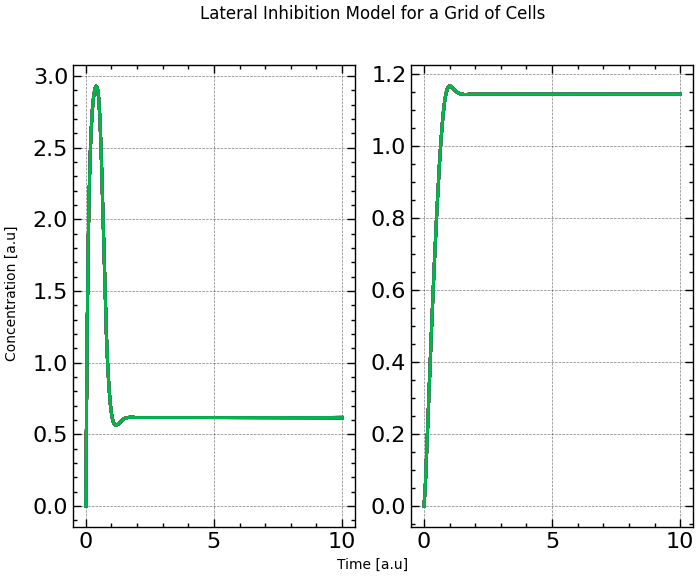

In [86]:
plt.style.use(['science', 'notebook', 'grid'])
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(8, 6))
ax[0].plot(t, D)
# lst1 = []
# for i in range(2*k):
#     lst1.append("D"+str(i))
# ax[0].legend(lst1)
ax[1].plot(t, R)
# lst2 = []
# for j in range(2*k):
#     lst2.append("R"+str(j))
# ax[1].legend(lst2)
fig.text(0.5, 0.04, 'Time [a.u]', ha='center')
fig.text(0.04, 0.5, 'Concentration [a.u]', va='center', rotation='vertical')
fig.suptitle('Lateral Inhibition Model for a Grid of Cells')
# plt.show()